# Import library

In [1]:
import numpy as np
import tensorflow as tf
import math
import logging
import matplotlib.pyplot as plot
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from numpy import mean
from numpy import sqrt
from numpy import absolute
import random

# Load Dataset

In [2]:
# Load dataset
# data = pd.read_excel("Concrete_Data.xls")
data = pd.read_excel("Concrete_Data.xls")
print(data)

      Cement (component 1)(kg in a m^3 mixture)  \
0                                         540.0   
1                                         540.0   
2                                         332.5   
3                                         332.5   
4                                         198.6   
...                                         ...   
1025                                      276.4   
1026                                      322.2   
1027                                      148.5   
1028                                      159.1   
1029                                      260.9   

      Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
0                                                   0.0       
1                                                   0.0       
2                                                 142.5       
3                                                 142.5       
4                                                 132.4       
...      

# Data Cleaning and Preprocessing

In [3]:
# Remove the row that contain null values and duplicate data
data.dropna(inplace = True)
data.drop_duplicates(inplace = True)

In [4]:
data.shape

(1005, 9)

In [5]:
#Fucntion of determine the range of outlier based on lower and upper bound of the dataset
def outliers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    ls = df.index[(df[ft] < lower_bound) | (df[ft] > upper_bound)]
    
    return ls

In [6]:
index_list = []
for feature in ['Cement (component 1)(kg in a m^3 mixture)','Blast Furnace Slag (component 2)(kg in a m^3 mixture)','Fly Ash (component 3)(kg in a m^3 mixture)','Water  (component 4)(kg in a m^3 mixture)','Superplasticizer (component 5)(kg in a m^3 mixture)','Coarse Aggregate  (component 6)(kg in a m^3 mixture)','Fine Aggregate (component 7)(kg in a m^3 mixture)','Age (day)']:
    index_list.extend(outliers(data,feature))

In [7]:
# Function to remove the outlier that determine from the original dataset
def remove(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

In [8]:
data_cleaned = remove(data,index_list)

In [9]:
data_cleaned.shape

(919, 9)

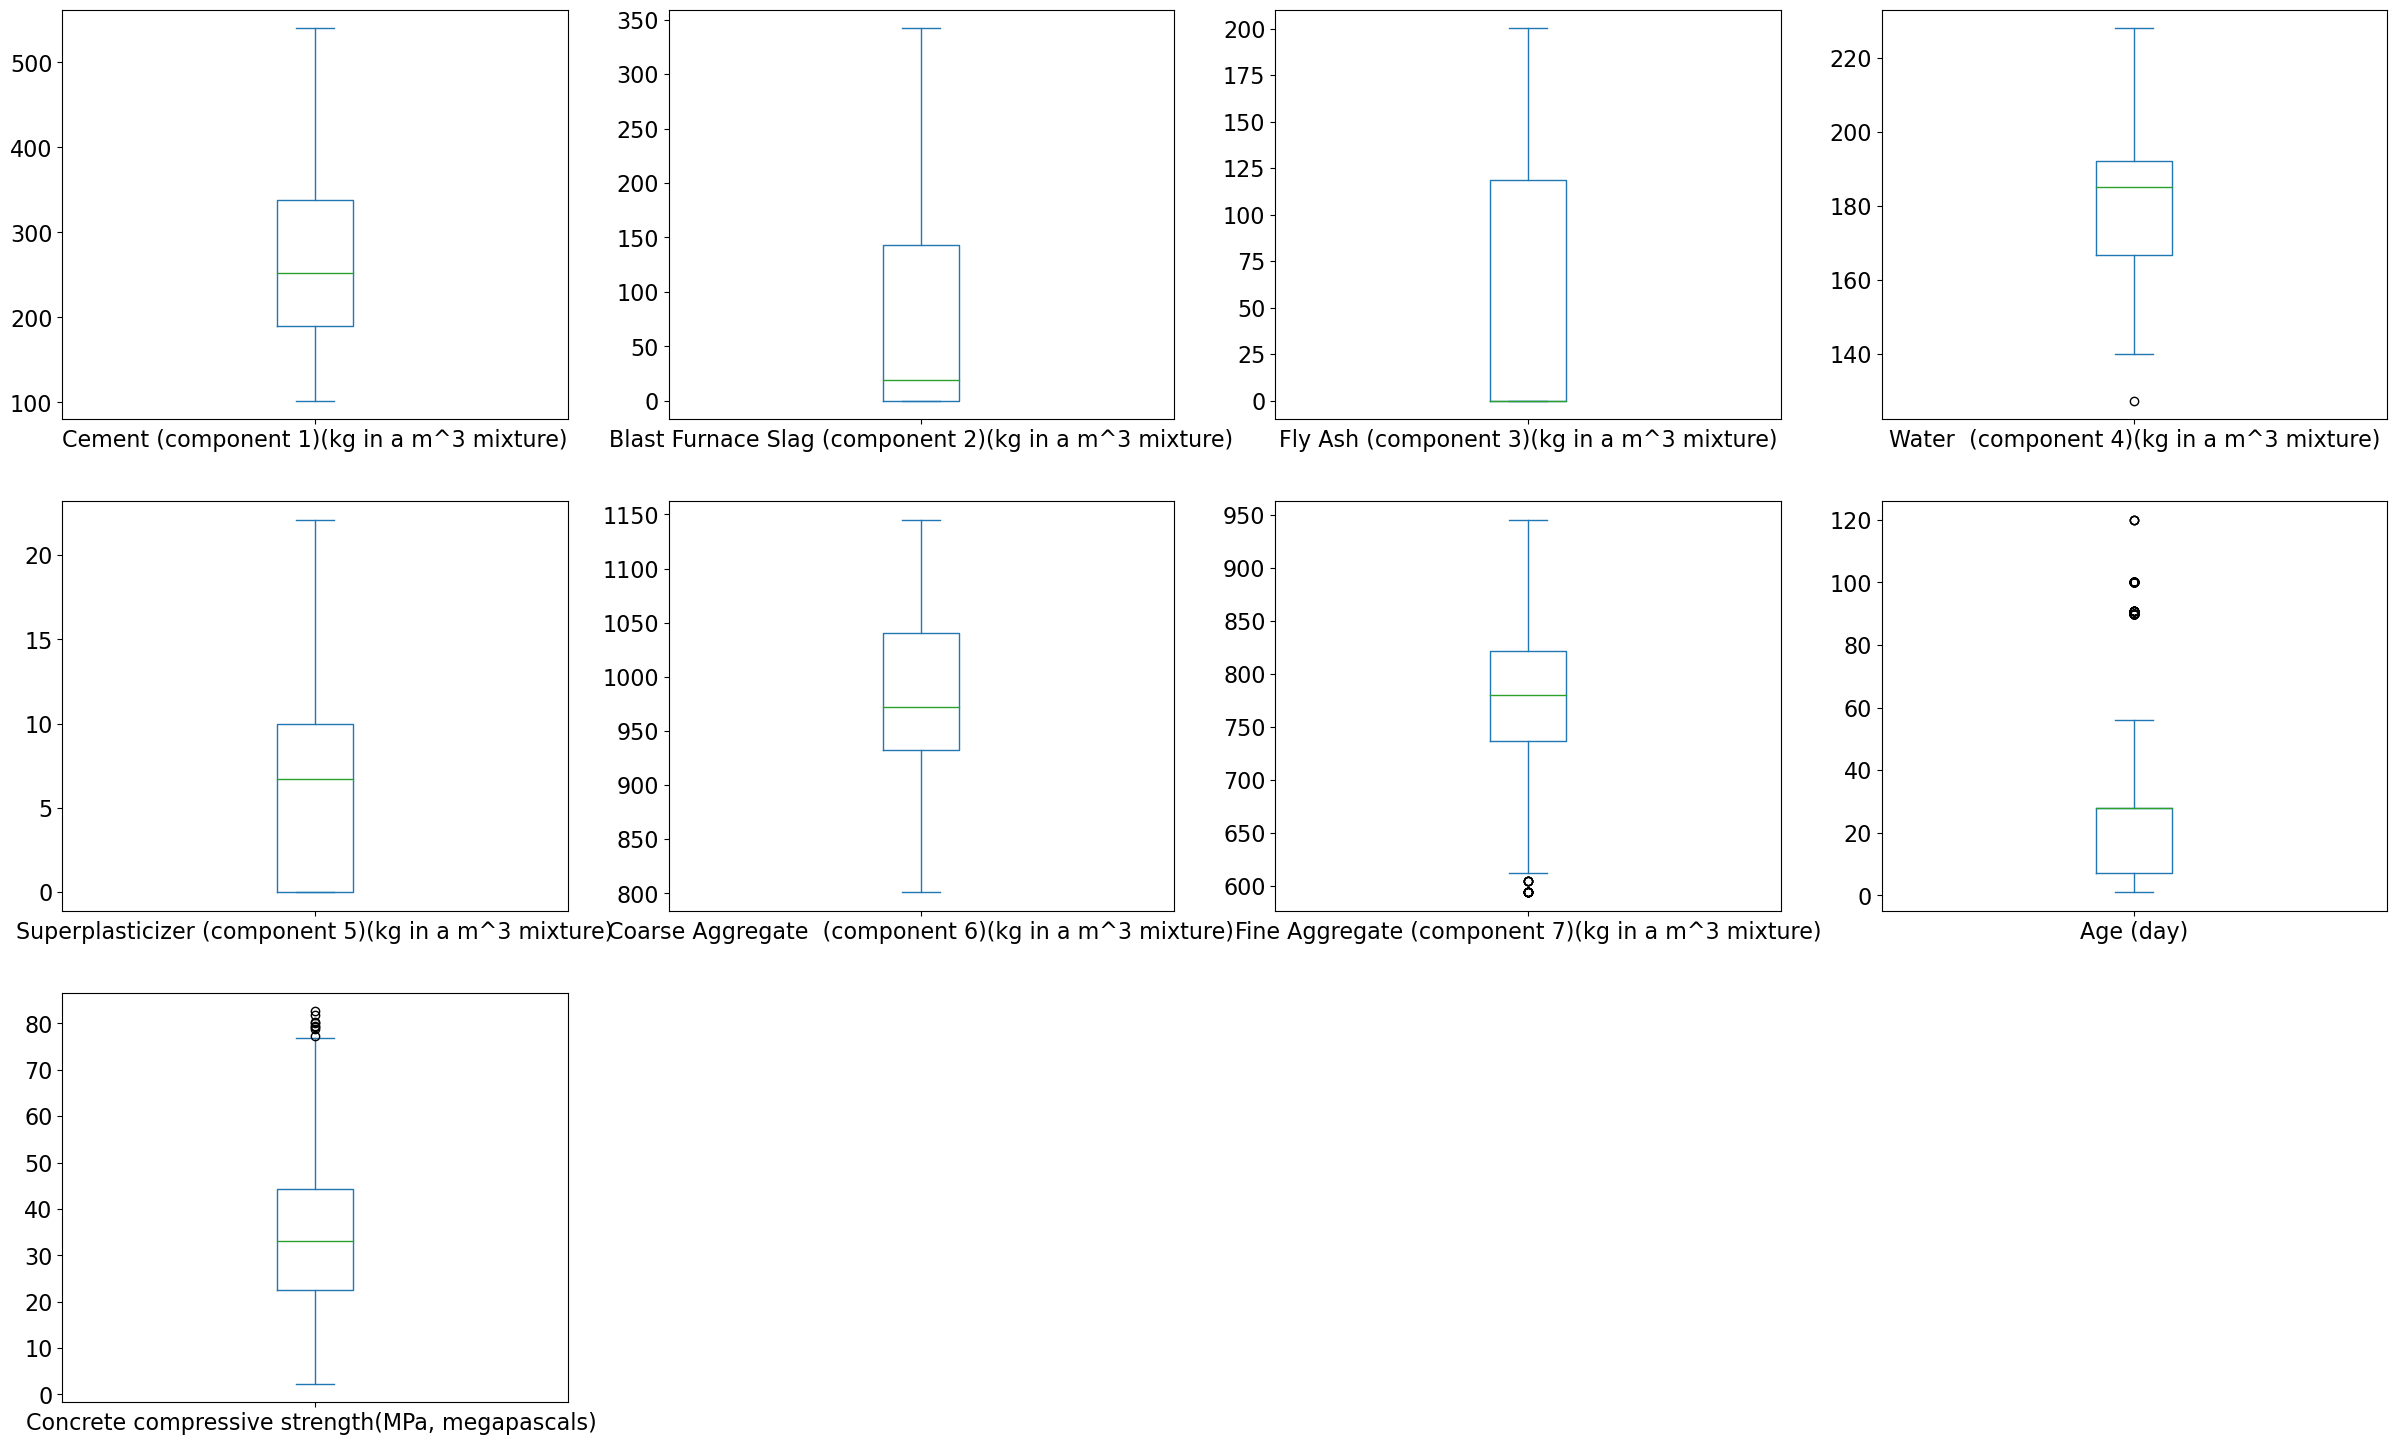

In [10]:
# Visualize the dataset after removing outlier
# There are still some outlier remain but mostly is removed
data_mean = data_cleaned.iloc[:,:]
data_mean.plot(kind='box', subplots=True, layout=(8,4), sharex=False,
sharey=False, fontsize=16, figsize=(30,50));

<AxesSubplot:>

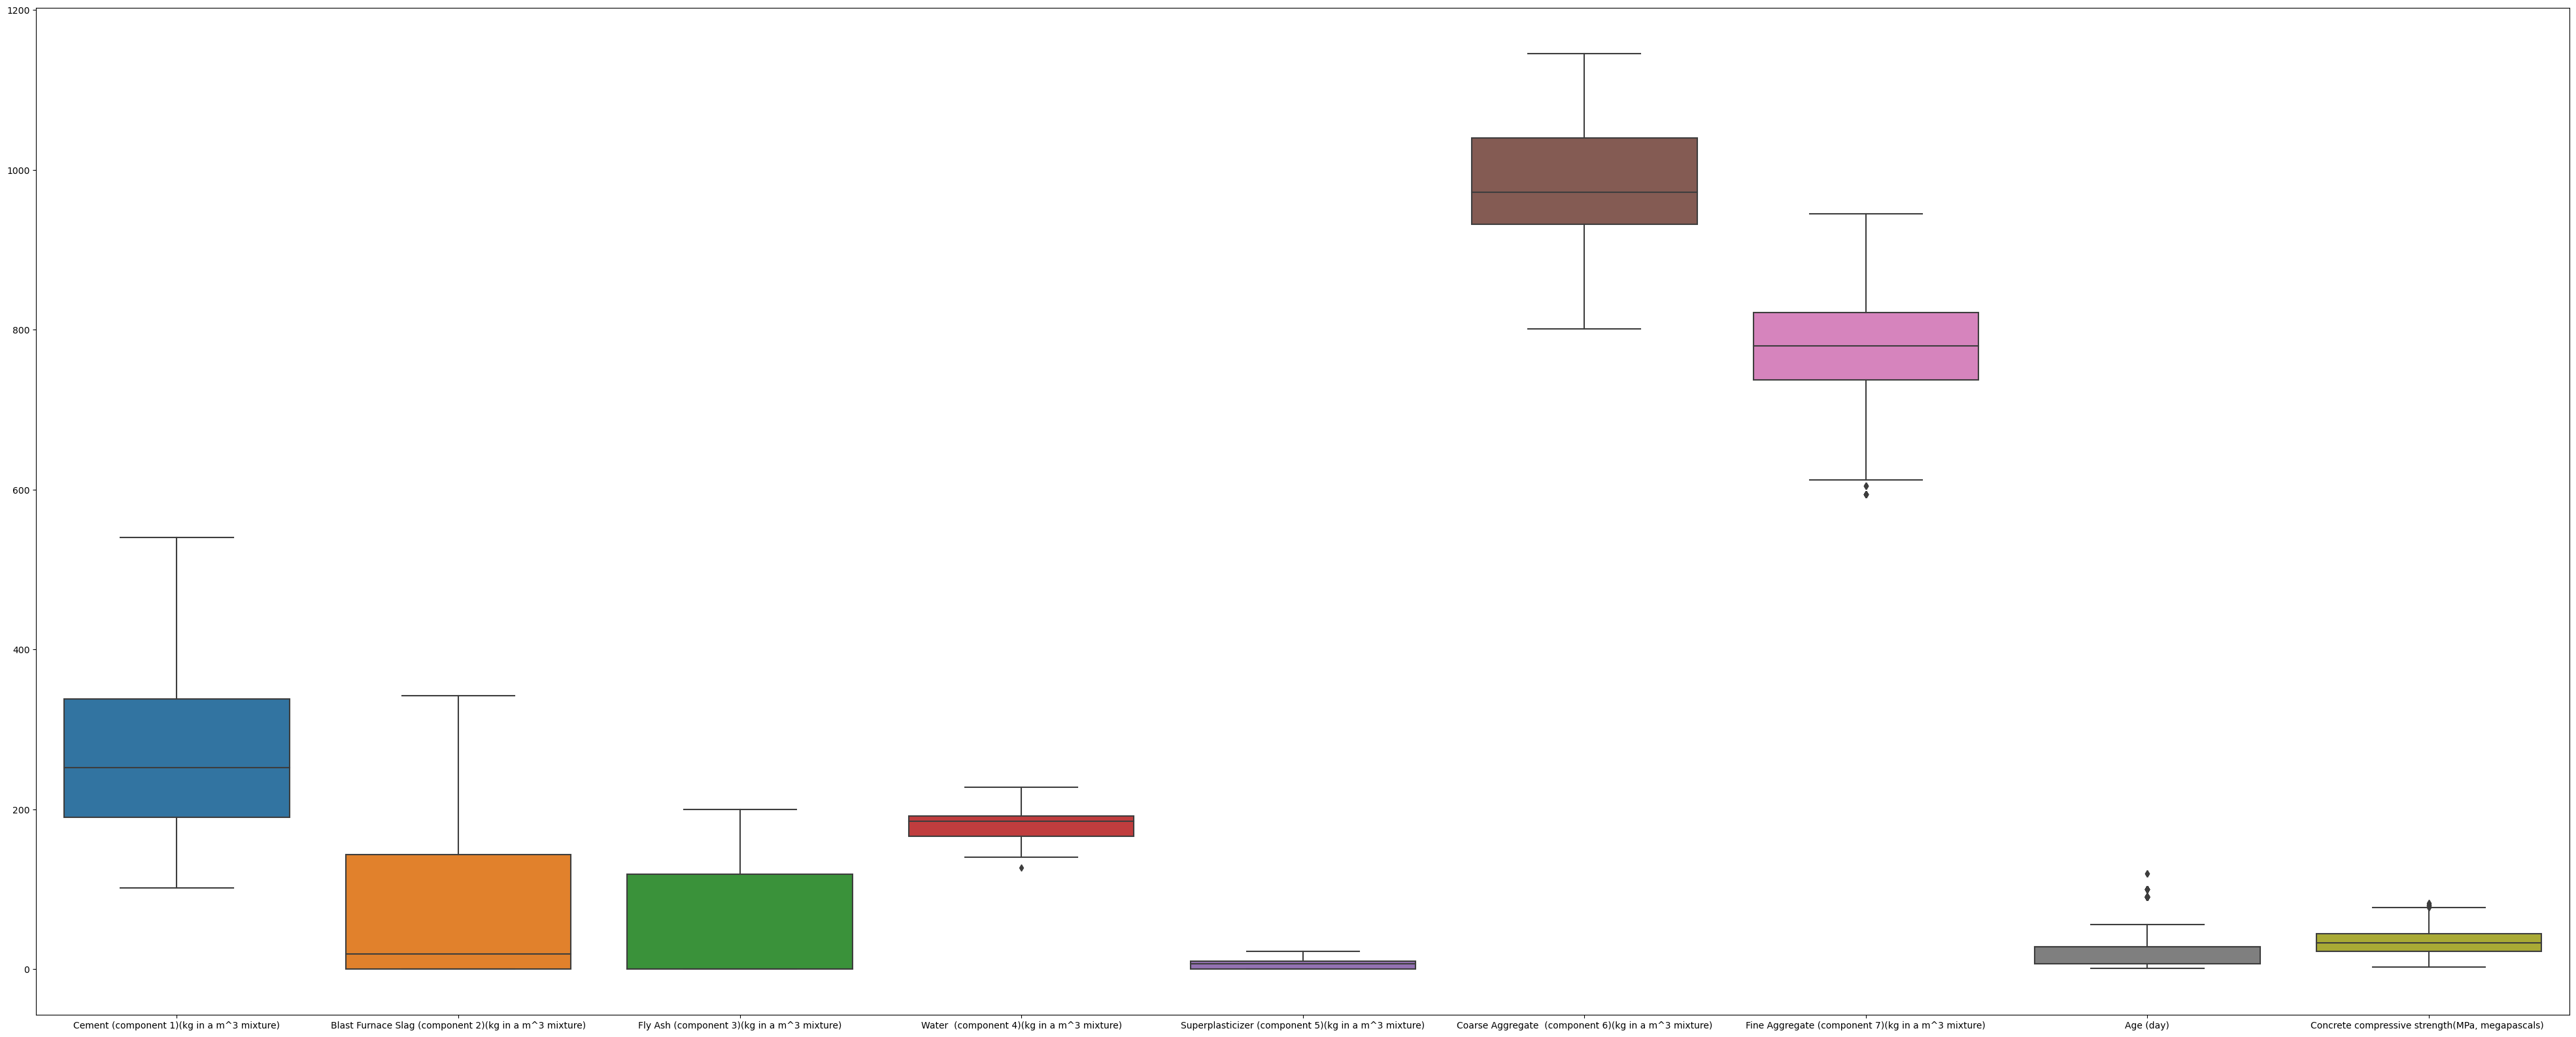

In [11]:
fig,ax=plot.subplots(1,figsize=(50,20))
sns.boxplot(data=data_cleaned.iloc[:, :],ax=ax) 

## HeatMap

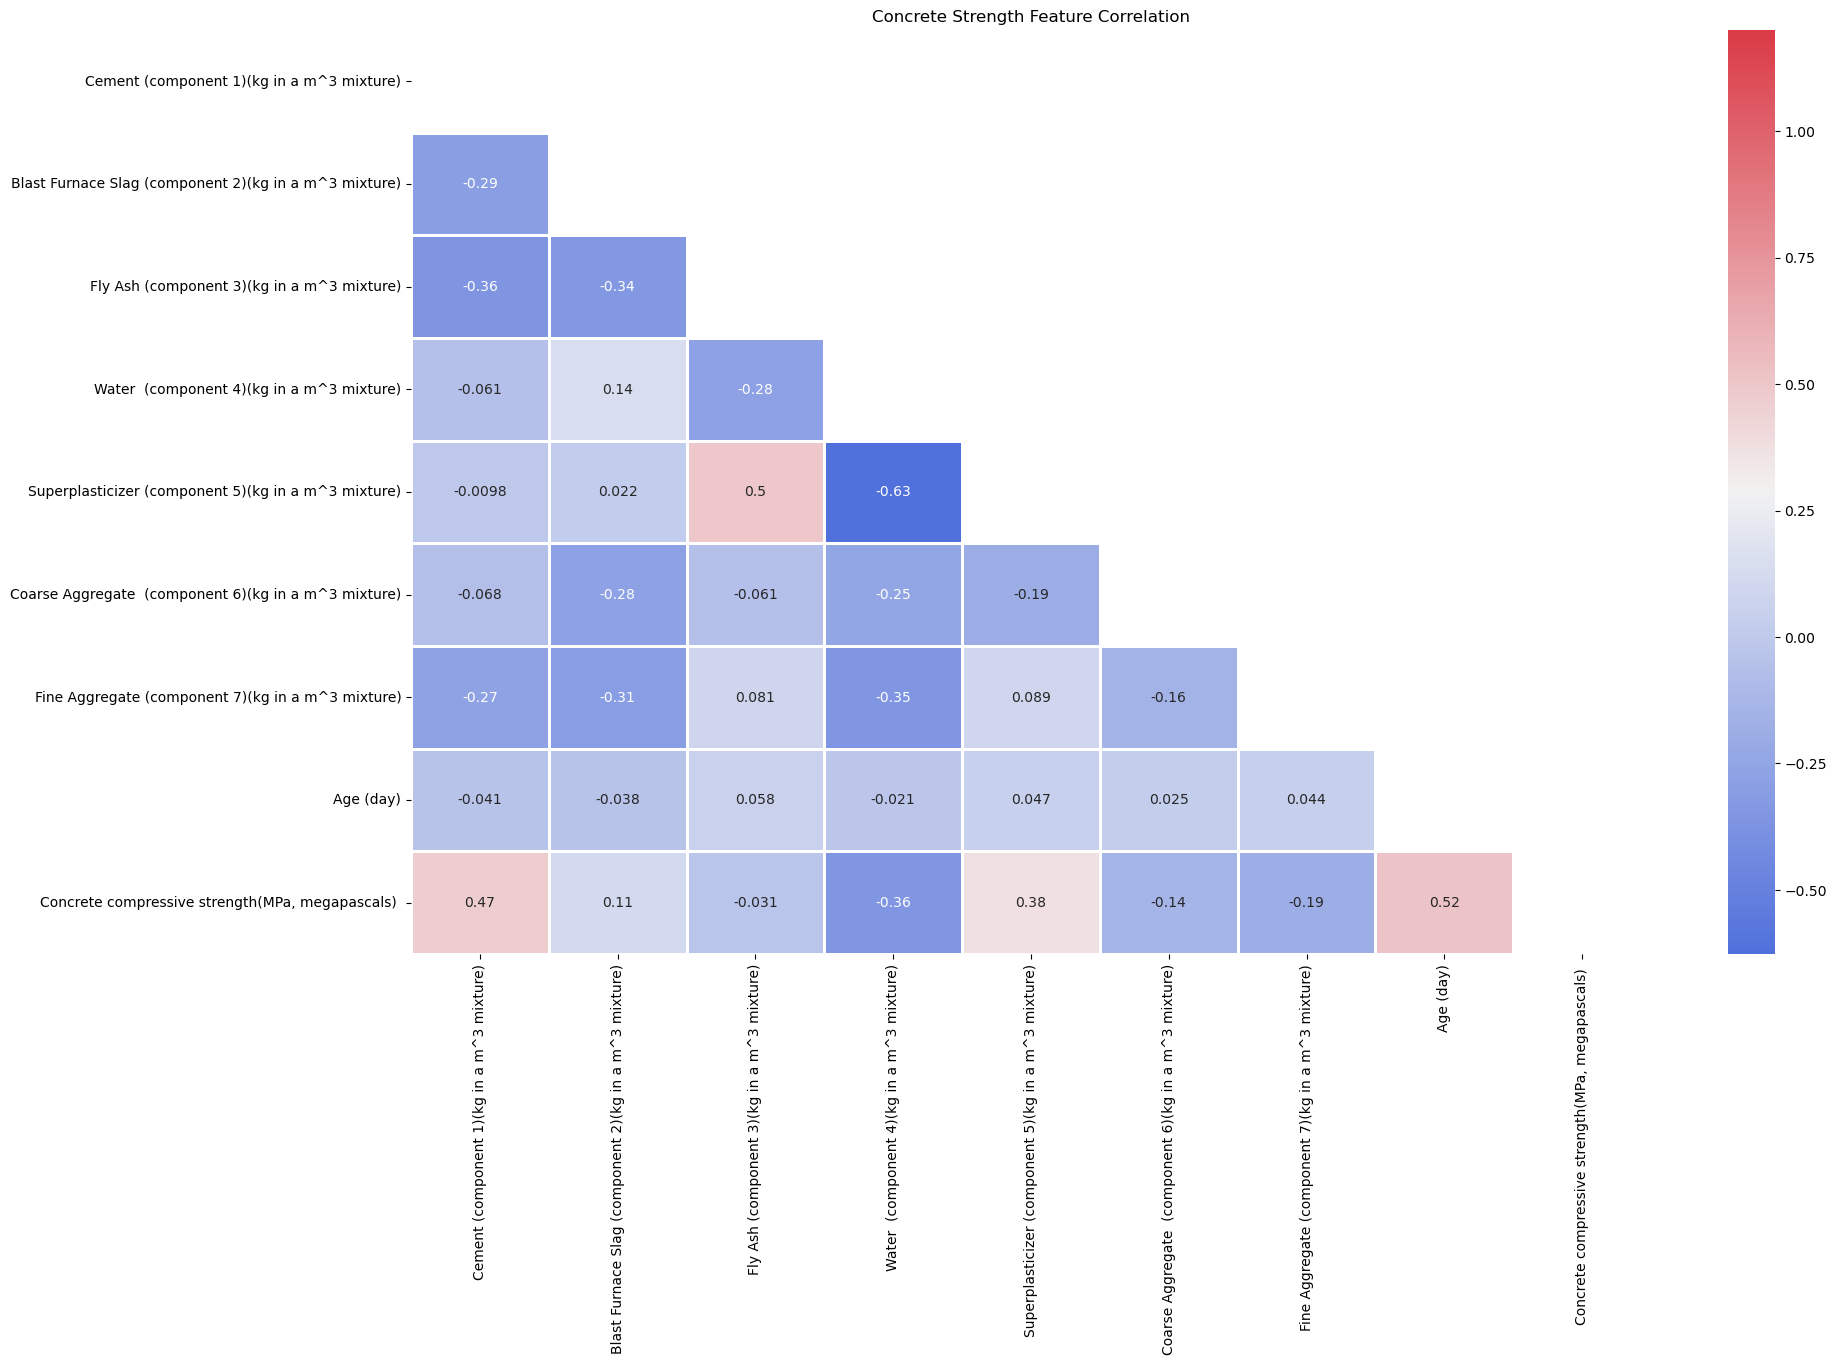

In [12]:
# Find and determine the corrrelation between data 
corrMatt = data_cleaned.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plot.subplots(figsize=(20,12))
plot.title('Concrete Strength Feature Correlation')
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask,
ax=ax, annot=True, fmt='.2g', linewidths=1);

## Normalize data

In [13]:
#Normalize data
from sklearn.preprocessing import StandardScaler

x = data_cleaned.iloc[:,:-1]
scaler = StandardScaler()
scaler.fit(x)

# transform the test test
Xs = scaler.transform(x)
Xs

array([[ 2.62175847, -0.83405014, -0.92165195, ...,  0.81865248,
        -1.32135637, -0.15158958],
       [ 2.62175847, -0.83405014, -0.92165195, ...,  1.01233482,
        -1.32135637, -0.15158958],
       [-0.07184464,  0.48474642, -0.92165195, ..., -0.57586039,
        -1.40118666,  2.02788842],
       ...,
       [-1.22694817,  0.77858354,  0.7631786 , ..., -1.08718177,
         0.06236868, -0.15158958],
       [-1.12274308,  1.32576843, -0.92165195, ...,  0.16787981,
         0.18078361, -0.15158958],
       [-0.12198105,  0.32857314,  0.29310157, ..., -1.44743093,
        -0.18377472, -0.15158958]])

<AxesSubplot:>

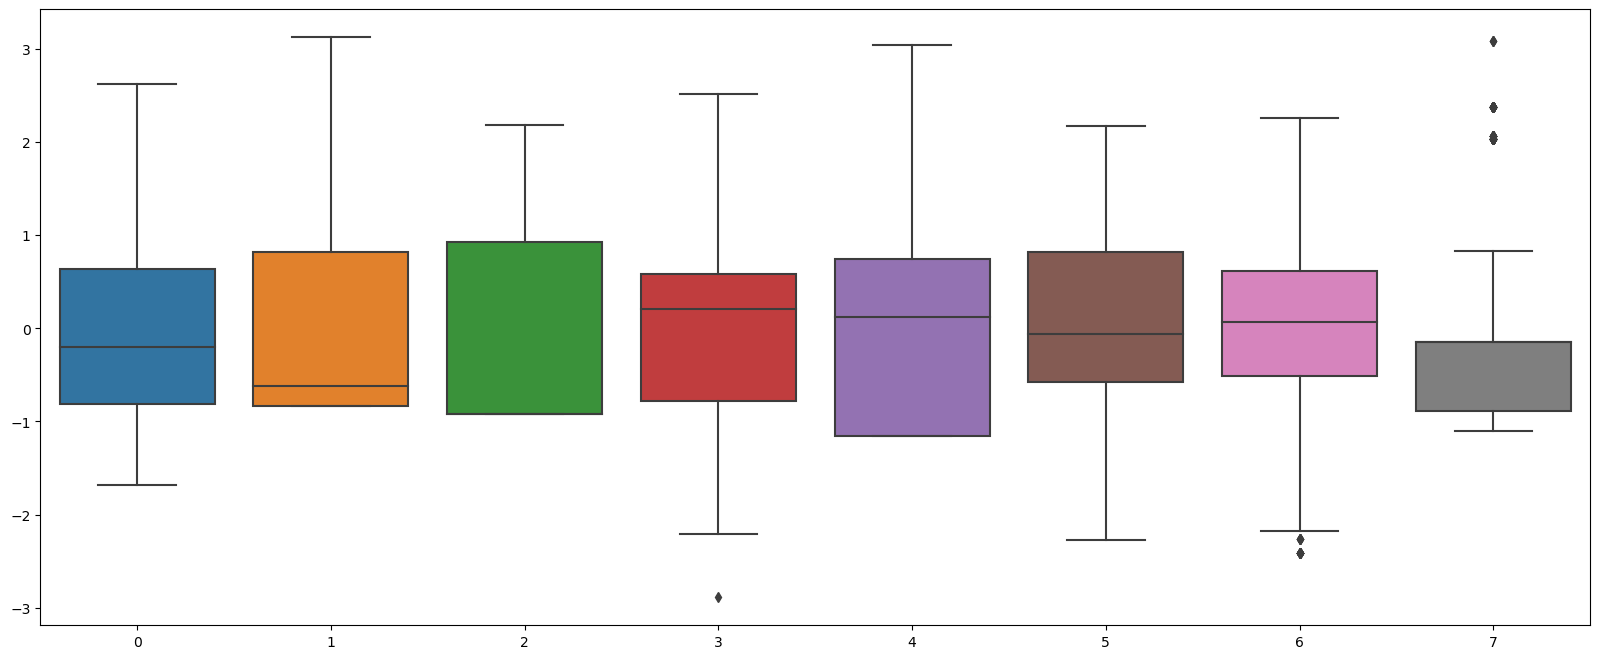

In [14]:
fig,ax=plot.subplots(1,figsize=(20,8))
sns.boxplot(data=Xs,ax=ax) 

In [15]:
# Assign the target value that used for prediction
y = data_cleaned['Concrete compressive strength(MPa, megapascals) ']
y

0       79.986111
1       61.887366
5       47.029847
7       36.447770
8       45.854291
          ...    
1025    44.284354
1026    31.178794
1027    23.696601
1028    32.768036
1029    32.401235
Name: Concrete compressive strength(MPa, megapascals) , Length: 919, dtype: float64

# Split dataset into test and training set

In [16]:
#Split train and test data for x and y
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs,y,test_size=0.3,random_state=1)
y_test

355     47.711739
692     39.700028
392     47.277369
432     26.200088
259     13.334466
          ...    
1021    31.875165
115     35.101223
625     32.922479
690     23.523542
897     40.934190
Name: Concrete compressive strength(MPa, megapascals) , Length: 276, dtype: float64

# Hyperparameter Tuning

In [17]:
parameter_space = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'epsilon' :[0.1,1.0,10],
    'C' : [1,5,10],
    'gamma':['scale','auto']}

In [18]:
model_svr = SVR()

In [19]:
from sklearn.model_selection import GridSearchCV

grid_model = GridSearchCV(model_svr, parameter_space, n_jobs=-1,cv=5)
grid_model.fit(Xs_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'epsilon': [0.1, 1.0, 10],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [20]:
# Show the best parameter setting
print('Best parameters found:\n', grid_model.best_params_)

Best parameters found:
 {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [21]:
# Show all results of the grid search
means = grid_model.cv_results_['mean_test_score']
stds = grid_model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.748 (+/-0.075) for {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
0.566 (+/-0.040) for {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.639 (+/-0.036) for {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.696 (+/-0.091) for {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.748 (+/-0.075) for {'C': 1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
0.568 (+/-0.044) for {'C': 1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
0.639 (+/-0.036) for {'C': 1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
0.695 (+/-0.090) for {'C': 1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.750 (+/-0.078) for {'C': 1, 'epsilon': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
0.568 (+/-0.031) for {'C': 1, 'epsilon': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.642 (+/-0.038) for {'C': 1, 'epsilon': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.694 (+/-0.083) for {'C': 1, 'epsilon': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.750 (+

# Apply Default SVM method (SVR)

In [22]:
#Apply Support Vector Regression (SVR)
# C will affect the result
# the higher, the better but may cause overfitting occur
default_model = SVR()
default_rgs = default_model.fit(Xs_train,y_train.ravel())

In [23]:
default_y_pred = default_rgs.predict(Xs_test)

In [24]:
# Determine the default svr score on testing dataset
default_rgs.score(Xs_test,y_test)

0.6953946262573516

In [25]:
# Compare the difference between the predicted value and actual value
pred_data = pd.DataFrame({'Actual':y_test,'Predicted':default_y_pred,'Difference':y_test-default_y_pred})
print(pred_data)

         Actual  Predicted  Difference
355   47.711739  36.365827   11.345912
692   39.700028  40.468632   -0.768604
392   47.277369  38.246866    9.030504
432   26.200088  27.809789   -1.609701
259   13.334466  25.405231  -12.070765
...         ...        ...         ...
1021  31.875165  34.038871   -2.163706
115   35.101223  40.998680   -5.897457
625   32.922479  40.248802   -7.326323
690   23.523542  25.960160   -2.436618
897   40.934190  41.567303   -0.633113

[276 rows x 3 columns]


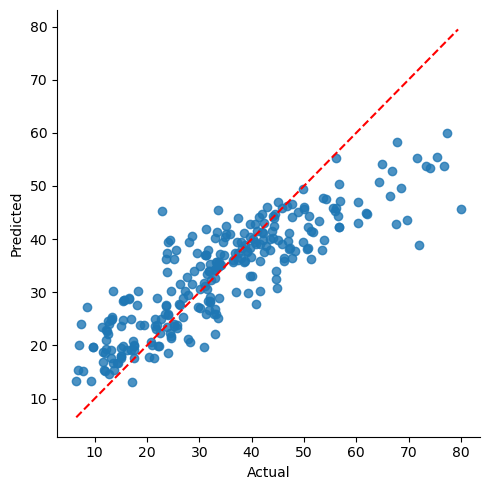

In [26]:
# Plot the prediction result with actual value for visualization
default_data_results = pd.DataFrame({'Actual':y_test,'Predicted':default_y_pred})
sns.lmplot(x='Actual',y='Predicted',data=default_data_results,fit_reg=False)
default_d_line= np.arange(default_data_results.min().min(), default_data_results.max().max())
plot.plot(default_d_line, default_d_line, color='red', linestyle='--')
plot.show()

# Apply best hyperparameter to SVR Model

In [27]:
# If the below opt_model is undetermined or facing problem to run,
# please uncomment the below model function before run as it is obtained from GridSearch and remove the one below.

# opt_model = SVR(C=10, epsilon=0.1, kernel='rbf', gamma='scale')

opt_model = SVR().set_params(**grid_model.best_params_)

In [28]:
opt_rgs = opt_model.fit(Xs_train,y_train.ravel())
opt_y_pred = opt_rgs.predict(Xs_test)

In [29]:
opt_rgs.score(Xs_test,y_test)

0.8655270929695248

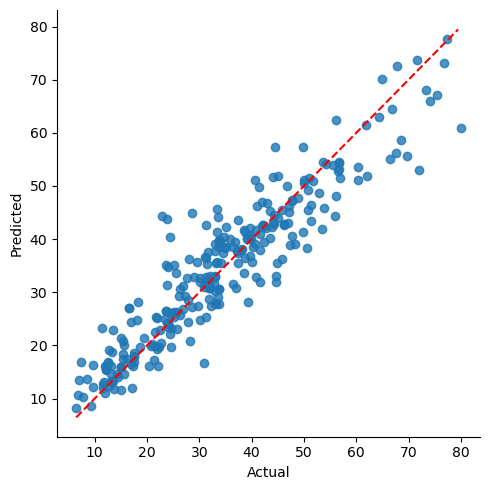

In [30]:
data_results = pd.DataFrame({'Actual':y_test,'Predicted':opt_y_pred})
sns.lmplot(x='Actual',y='Predicted',data=data_results,fit_reg=False)
d_line= np.arange(data_results.min().min(), data_results.max().max())
plot.plot(d_line, d_line, color='red', linestyle='--')
plot.show()

# Using K-fold Cross Validation to determine the Result of Model with Default Hyperparameter

In [31]:
#K-fold validation
from sklearn.model_selection import cross_val_score

In [32]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

In [33]:
#K-Fold R2 Score
r2_scores = cross_val_score(default_model, Xs, y, scoring='r2', cv=cv, n_jobs=-1)
print("K-Fold R2 score =", round(np.mean(r2_scores),2))

K-Fold R2 score = 0.7


In [34]:
#K-Fold Mean Squared Error
MSE = cross_val_score(default_model, Xs, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("K-Fold Mean Squared Error =", round(np.mean(absolute(MSE)),2))

K-Fold Mean Squared Error = 79.41


In [35]:
#K-Fold Root Mean Squared Error
RMSE = cross_val_score(default_model, Xs, y, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("K-Fold Root Mean Squared error =", round(np.mean(absolute(RMSE)),2))

K-Fold Root Mean Squared error = 8.9


# Using K-fold Cross Validation to determine the Result of Model with Best Hyperparameter


In [36]:
#K-Fold R2 Score
opt_r2_scores = cross_val_score(opt_model, Xs, y, scoring='r2', cv=cv, n_jobs=-1)
print("K-Fold R2 score =", round(np.mean(opt_r2_scores),2))

K-Fold R2 score = 0.86


In [37]:
#K-Fold Mean Squared Error
opt_MSE = cross_val_score(opt_model, Xs, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("K-Fold Mean Squared Error =", round(np.mean(np.absolute(opt_MSE)),2))

K-Fold Mean Squared Error = 36.58


In [38]:
#K-Fold Root Mean Squared Error
opt_RMSE = cross_val_score(opt_model, Xs, y, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("K-Fold Root Mean Squared error =", round(np.mean(np.absolute(opt_RMSE)),2))

K-Fold Root Mean Squared error = 6.04
